In [5]:
# Basic regression to predict fuel efficiency
# Code is based on this tutorial: https://www.tensorflow.org/tutorials/keras/regression
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pip install pandas

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [6]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [7]:
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)

In [8]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [9]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [10]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [11]:
# Split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [12]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [13]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10, 8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

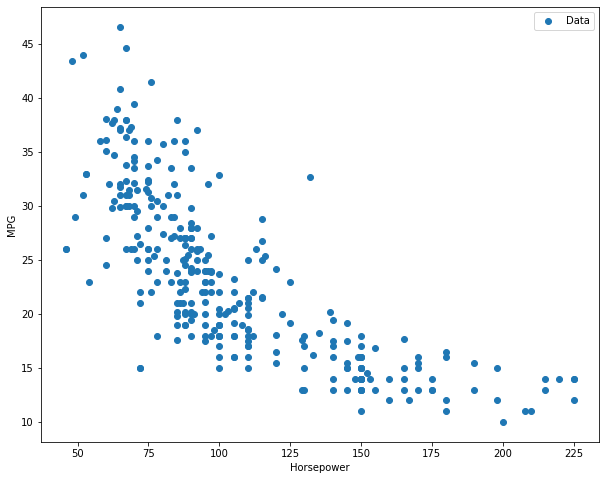

In [14]:
plot('Horsepower')

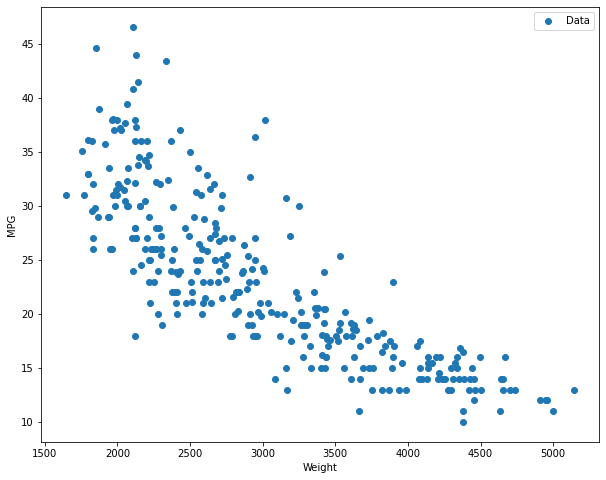

In [15]:
plot('Weight')

In [17]:
# Normalize
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
    0.197]


In [18]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean)/stddev
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [22]:
# Regression
 # 1. Normalize the input horsepower
 # 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


In [23]:
# Sequential model
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

In [24]:
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [25]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError() # MeanSquaredError
optim = keras.optimizers.Adam(lr=0.1)

single_feature_model.compile(optimizer=optim, loss=loss)

In [26]:
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 30ms/step - loss: 22.8746 - val_loss: 22.9301
Epoch 2/100
8/8 [==============================] - 0s 10ms/step - loss: 22.0649 - val_loss: 22.1304
Epoch 3/100
8/8 [==============================] - 0s 7ms/step - loss: 21.2626 - val_loss: 21.3305
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 20.4625 - val_loss: 20.5305
Epoch 5/100
8/8 [==============================] - 0s 11ms/step - loss: 19.6630 - val_loss: 19.7305
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 18.8656 - val_loss: 18.9303
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 18.0650 - val_loss: 18.1303
Epoch 8/100
8/8 [==============================] - 0s 8ms/step - loss: 17.2669 - val_loss: 17.3307
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 16.4638 - val_loss: 16.5309
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 15.6646 - val_loss: 15.7310
Epoch

Epoch 84/100
8/8 [==============================] - 0s 10ms/step - loss: 3.8049 - val_loss: 4.1929
Epoch 85/100
8/8 [==============================] - 0s 12ms/step - loss: 3.8024 - val_loss: 4.2010
Epoch 86/100
8/8 [==============================] - 0s 7ms/step - loss: 3.8044 - val_loss: 4.1927
Epoch 87/100
8/8 [==============================] - 0s 6ms/step - loss: 3.8070 - val_loss: 4.2144
Epoch 88/100
8/8 [==============================] - 0s 8ms/step - loss: 3.8057 - val_loss: 4.1810
Epoch 89/100
8/8 [==============================] - 0s 7ms/step - loss: 3.8051 - val_loss: 4.1695
Epoch 90/100
8/8 [==============================] - 0s 9ms/step - loss: 3.8037 - val_loss: 4.1931
Epoch 91/100
8/8 [==============================] - 0s 8ms/step - loss: 3.8061 - val_loss: 4.2034
Epoch 92/100
8/8 [==============================] - 0s 9ms/step - loss: 3.8035 - val_loss: 4.1782
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 3.8068 - val_loss: 4.1842
Epoch 94/100
8/8 [

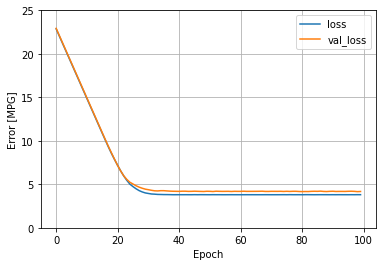

In [27]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [28]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 16ms/step - loss: 3.6535


3.6534581184387207

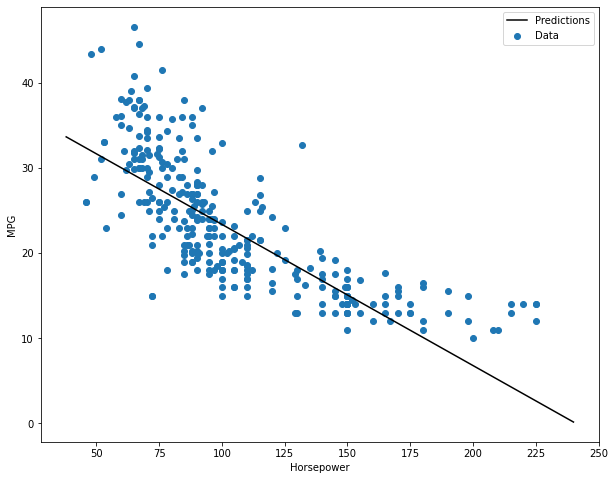

In [29]:
# predict and plot
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
    
plot(feature, x,y)

In [30]:
# DNN
dnn_model = keras.Sequential([
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [31]:
dnn_model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [32]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 28ms/step - loss: 23.1184 - val_loss: 23.4752
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 22.8437 - val_loss: 23.1808
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 22.5650 - val_loss: 22.8625
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 22.2400 - val_loss: 22.4783
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 21.8378 - val_loss: 21.9887
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 21.3144 - val_loss: 21.3656
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 20.6490 - val_loss: 20.5751
Epoch 8/100
8/8 [==============================] - 0s 11ms/step - loss: 19.8110 - val_loss: 19.5738
Epoch 9/100
8/8 [==============================] - 0s 13ms/step - loss: 18.7583 - val_loss: 18.4103
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 17.6094 - val_loss: 17.1353
Ep

In [33]:
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 2.9962


2.9962339401245117

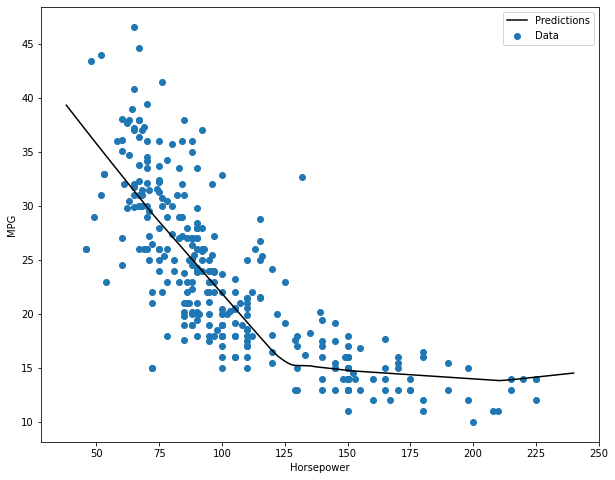

In [34]:
# predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x,y)

In [35]:
# multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss)

In [36]:
linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 0s 25ms/step - loss: 22.9506 - val_loss: 22.9974
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 22.0630 - val_loss: 22.2919
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 21.2259 - val_loss: 21.5781
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 20.4071 - val_loss: 20.8370
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 19.5825 - val_loss: 20.1105
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 18.7970 - val_loss: 19.3990
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 17.9480 - val_loss: 18.6812
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 17.1278 - val_loss: 17.9446
Epoch 9/100
8/8 [==============================] - 0s 7ms/step - loss: 16.3200 - val_loss: 17.2069
Epoch 10/100
8/8 [==============================] - 0s 9ms/step - loss: 15.5129 - val_loss: 16.4912
Epoc

Epoch 84/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4922 - val_loss: 2.4794
Epoch 85/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4800 - val_loss: 2.5546
Epoch 86/100
8/8 [==============================] - 0s 11ms/step - loss: 2.4749 - val_loss: 2.4698
Epoch 87/100
8/8 [==============================] - 0s 9ms/step - loss: 2.4917 - val_loss: 2.4972
Epoch 88/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4712 - val_loss: 2.4932
Epoch 89/100
8/8 [==============================] - 0s 9ms/step - loss: 2.4757 - val_loss: 2.4814
Epoch 90/100
8/8 [==============================] - 0s 16ms/step - loss: 2.4905 - val_loss: 2.4918
Epoch 91/100
8/8 [==============================] - 0s 10ms/step - loss: 2.4783 - val_loss: 2.4839
Epoch 92/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4753 - val_loss: 2.4988
Epoch 93/100
8/8 [==============================] - 0s 8ms/step - loss: 2.4777 - val_loss: 2.4724
Epoch 94/100
8/

In [37]:
linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 2.5095


2.509455919265747